# Import Libs

In [1]:
# from pprint import pprint as print
import json
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
# copy files
import shutil
# json
import json
# rich
from rich import print
import pprint
import uuid
import time
import random
# python dot env
from dotenv import load_dotenv

In [2]:
from typing import List, Dict, Any, Optional
from pydantic import BaseModel, Field, model_validator, ConfigDict
from typing import Annotated, Sequence, Any, Literal
from typing_extensions import TypedDict

In [3]:
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic
from langgraph.prebuilt import create_react_agent
#
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools import tool, StructuredTool
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from IPython.display import Image, display
from langchain_core.messages import ToolMessage, AIMessage, HumanMessage, BaseMessage, SystemMessage
from langgraph.prebuilt import ToolNode, tools_condition
import operator
from langgraph.types import Command, interrupt
from langgraph.prebuilt import create_react_agent, InjectedState
from langchain.tools.retriever import create_retriever_tool
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate
from langchain_core.tools.base import InjectedToolCallId
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser, PydanticOutputParser

c:\My Drive\apps\LLM-Exp\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# API Keys

In [4]:
# API Keys
load_dotenv()

# langchain
os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY')
os.environ['LANGCHAIN_TRACING_V2'] = os.getenv('LANGCHAIN_TRACING_V2')

# open ai
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
# gemeni
os.environ['GOOGLE_API_KEY'] = os.getenv('GOOGLE_API_KEY')
# anthropic
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY')

# Models

In [5]:
# open ai
llm_openai = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    max_retries=2
)

In [6]:
# gemini
llm_gemini = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0,
    max_retries=2,
    # other params...
)

In [7]:
# model name
model_name = 'claude-3-5-haiku-latest'

# anthropic llm
llm_anthropic = ChatAnthropic(
    model=model_name, temperature=0
)

# Utils

In [8]:
# Generate Thread Id
def generate_thread_id():
    return str(uuid.uuid4())


def generate_thread():
    """Generate a thread"""
    # thread id
    thread_id = generate_thread_id()
    # thread
    thread = {
        'configurable': {
            'thread_id': thread_id
        }
    }
    # return
    return thread, thread_id

# Tools

In [34]:
@tool
def generate_city(country: str):
    """
    Generate a random city

    Args:
        country (str): Country name
    """
    # city list
    canada_city_list = ['Quebec', 'Toronto', 'Vancouver', 'Montreal', 'Ottawa',
                 'Calgary', 'Edmonton', 'Winnipeg', 'Halifax', 'Victoria']
    # usa
    usa_city_list = ['New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix',
                 'Philadelphia', 'San Antonio', 'San Diego', 'Dallas', 'San Jose']
    # mexico
    mexico_city_list = ['Mexico City', 'Ecatepec', 'Guadalajara', 'Puebla', 'Juárez',
                 'Tijuana', 'León', 'Zapopan', 'Monterrey', 'Nezahualcóyotl']

    if country.lower() == 'canada':
        # random id
        id = random.randint(0, len(canada_city_list) - 1)
        # return
        return canada_city_list[id]
    elif country.lower() == 'usa':
        # random id
        id = random.randint(0, len(usa_city_list) - 1)
        # return
        return usa_city_list[id]
    elif country.lower() == 'mexico':
        # random id
        id = random.randint(0, len(mexico_city_list) - 1)
        # return
        return mexico_city_list[id]
    else:
        return "Invalid Country"


@tool
def predict_weather(city: str, season: str):
    """
    Predict the weather of a city

    Args:
        city (str): City name
        season (str): Season name
    """
    # check season
    if season.lower() == 'winter':
        # weather
        weather = {
            'city': city,
            'temperature': random.randint(-10, 10),
            'humidity': random.randint(0, 100),
            'wind': random.randint(0, 50)
        }
    elif season.lower() == 'spring':
        # weather
        weather = {
            'city': city,
            'temperature': random.randint(10, 20),
            'humidity': random.randint(0, 100),
            'wind': random.randint(0, 50)
        }
    elif season.lower() == 'summer':
        # weather
        weather = {
            'city': city,
            'temperature': random.randint(20, 30),
            'humidity': random.randint(0, 100),
            'wind': random.randint(0, 50)
        }
    elif season.lower() == 'fall':
        # weather
        weather = {
            'city': city,
            'temperature': random.randint(10, 20),
            'humidity': random.randint(0, 100),
            'wind': random.randint(0, 50)
        }
    else:
        weather = 'Season not provided!'

    # return
    return weather

# Graph

## Graph State

In [10]:
class State(MessagesState):
    """graph state"""
    next: str
    human_approval: bool = False
    block_signal: str = ""

## Supervisor

In [38]:
# NOTE
# select model
llm = llm_openai

# blocks
members = ["city", "weather"]
# options (routes)
options = members + ["FINISH"]

# system prompt
supervisor_system_prompt = f"""You are a supervisor tasked with managing a conversation between the following workers: {members}.
Given the following user request, respond with the worker to act next. Each worker will perform a task and respond with their results and status.

**Tasks to Manage:**
- **city**: you are expected to choose a city using ONLY the tools provided.
- **weather**: you are expected to predict weather for a city using ONLY the tools provided.

**Instructions:**
- When not sure to route to the following workers: {members} responds with **CHAT-WITH-USER**.
- When finished all tasks, respond with **FINISH** and more explain.
- When selecting a city done, respond with prefix **TASK-1-DONE**.
- When predicting weather done, respond with prefix **TASK-2-DONE**.
- **Never** use any external information."""

class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal["city", "weather", "FINISH", "CHAT-WITH-USER", "TASK-1-DONE", "TASK-2-DONE"]

# NOTE: Supervisor

def supervisor_node(state: State) -> Command[Literal["city", "weather", "human", "__end__"]]:
    """supervisor node"""
    #  check messages
    messages = state["messages"]
    # last message
    last_message = messages[-1]

    # human approval
    human_approval = state.get("human_approval", False)

    # set message
    messages = [
        {"role": "system", "content": supervisor_system_prompt},
    ] + [last_message]

    # ask llm to route to next worker
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]

    # check response
    if goto == "FINISH":
        goto = END

    # check human approval
    if goto == "CHAT-WITH-USER" or goto == "TASK-1-DONE" or goto == "TASK-2-DONE":
        goto = "human"
        human_approval = True
        message = AIMessage(
            content=f"CHAT-WITH-USER: {last_message.content}"
        )

        return Command(
            goto=goto,
            update={
                "next": goto,
                "human_approval": human_approval,
                "messages": [message]
                })

    return Command(
            goto=goto,
            update={
                "next": goto,
                "human_approval": human_approval
                })



## Human (Chat)

In [39]:
# NOTE: human node
prompt_human = """"You are an expert to chat with user to collect information. \n

**Instructions:**
- Check message and then make a question to ask user. \n
- When you get user answer call relevant tools. \n
- **Never** predict anything or use any external information. \n

Here is the input-message: \n
"""

class CityTool(BaseModel):
    """City tool"""
    response: str = Field(description="city tool perform tasks related to city generation")

class WeatherTool(BaseModel):
    """Weather tool"""
    response: str = Field(description="weather tool to predict tasks related to weather prediction")


# # human model
llm_human = llm.bind_tools([CityTool, WeatherTool])

def human_node(state: State):
    # system message
    system_message = [SystemMessage(
        content=prompt_human
    )]
    # set message
    messages = system_message + state["messages"]
    # invoke
    response = llm_human.invoke(messages)

    # return
    return {
        "messages": [response],
        "human_approval": True
        }

def human_state_node(state: State) -> Command[Literal["human", "HumanToolMessage", "__end__"]]:
    """human state"""
    # messages
    messages = state["messages"]
    # last message
    last_message = messages[-1]

    # goto
    goto = "human"
    # human approval
    human_approval = True

    # check
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        goto = "HumanToolMessage"
        human_approval = False
    elif not isinstance(last_message, HumanMessage):
        goto = END

    return Command(
        update={"human_approval": human_approval},
        goto=goto
        )

def human_tool_message(state: State) -> Command[Literal["city", "weather", "supervisor"]]:
    # messages
    messages = state["messages"]
    # last message
    last_message = messages[-1]
    # tool name
    tool_name = last_message.tool_calls[0]["name"]
    # tool call id
    tool_call_id = last_message.tool_calls[0]["id"]
    # args
    tool_args = last_message.tool_calls[0]["args"]

    # block signal
    block_signal = state.get("block_signal", "supervisor")

    # check tool name
    if tool_name == "CityTool":
        # set
        human_approval_res = CityTool(**tool_args)
    elif tool_name == "WeatherTool":
        # set
        human_approval_res = WeatherTool(**tool_args)

    # user response
    user_response = human_approval_res.response

    # tool message
    tool_message = [ToolMessage(
        content=human_approval_res,
        tool_call_id=tool_call_id
    )]

    # ai message
    human_message = [HumanMessage(
        content=f"I have all information required for {block_signal}: user response: {user_response}, block-signal: {block_signal}"
    )]

    # return
    return Command(
        update={
            "messages": tool_message + human_message,
            "human_approval": False,
            "block_signal": block_signal
            },
        goto=block_signal
    )


# NOTE: conditional START
def start_state(state: State):
    # human approval
    human_approval = state.get("human_approval", False)
    print(f"human_approval: {human_approval}")

    # check
    if human_approval == False:
        return 'supervisor'
    else:
        return 'human'

## Agents 1

In [40]:
# NOTE: Agent 1
prompt_agent_1 = """You are expected to choose a city from **country name** using ONLY the tools provided.\n

**Instructions:**
- User MUST provide a country name, if not, you MUST ask user.
- When the task is finished, respond with prefix 'TASK-1-DONE' and explain you can now go for predict weather.\n
- When encounter any data required, ask user to provide the information, and respond with prefix 'CHAT-WITH-USER'.\n
- **Never** predict anything or use any external information.\n
"""
city_agent = create_react_agent(
    llm, tools=[generate_city], state_modifier=prompt_agent_1
)


def city_node(state: State) -> Command[Literal["supervisor", "human"]]:
    result = city_agent.invoke(state)

    # check result
    if "CHAT-WITH-USER" in result["messages"][-1].content:
        return Command(
            update={
                "messages": [
                    HumanMessage(content=result["messages"]
                                [-1].content, name="city-agent")
                ],
                "human_approval": True,
                "block_signal": "city"
            },
            goto="human",
        )

    # return
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"]
                             [-1].content, name="city-agent")
            ]
        },
        goto="supervisor",
    )


## Agent 2

In [41]:
# NOTE: Agent 2
prompt_agent_2 = """You are expected to predict weather based on **city name** and **season name** using ONLY the tools provided.\n

**Instructions:**
- User MUST provide a season name, if not, you MUST ask user. \n
- When the task is finished, respond with prefix 'TASK-2-DONE'.\n
- When encounter any data required, ask user to provide the information, and respond with prefix 'CHAT-WITH-USER'.\n
- **Never** use any external information.\n
"""
weather_agent = create_react_agent(
    llm, tools=[predict_weather], state_modifier=prompt_agent_2
)

def weather_node(state: State) -> Command[Literal["supervisor", "human"]]:
    result = weather_agent.invoke(state)

    # check result
    if "CHAT-WITH-USER" in result["messages"][-1].content:
        return Command(
            update={
                "messages": [
                    HumanMessage(content=result["messages"]
                                [-1].content, name="weather-agent")
                ],
                "human_approval": True,
                "block_signal": "weather"
            },
            goto="human",
        )

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"]
                             [-1].content, name="weather-agent")
            ]
        },
        goto="supervisor",
    )

## Create Graph

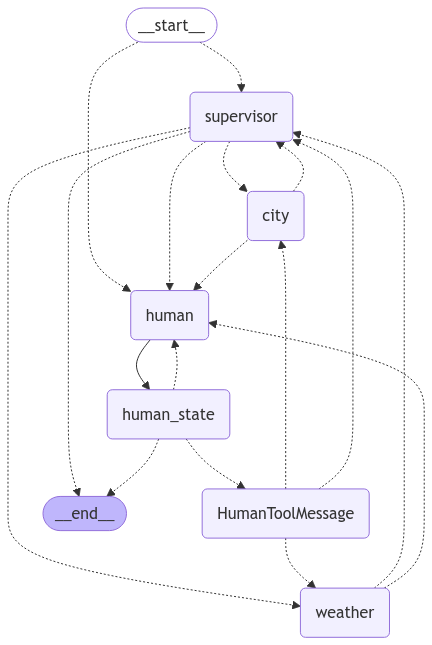

In [42]:
# memory
memory = MemorySaver()

# create graph
builder = StateGraph(State)
# nodes
builder.add_node("supervisor", supervisor_node)
builder.add_node("city", city_node)
builder.add_node("weather", weather_node)
builder.add_node("human", human_node)
builder.add_node("HumanToolMessage", human_tool_message)
builder.add_node("human_state", human_state_node)

# edges
builder.add_conditional_edges(START, start_state, ['supervisor', 'human'])
builder.add_edge("human", "human_state")

# compile
graph = builder.compile(checkpointer=memory)

# visualize
display(Image(graph.get_graph(xray=False).draw_mermaid_png()))

# Streaming

In [43]:
# thread
thread, thread_id = generate_thread()
print(f"thread: {thread}")

thread: {'configurable': {'thread_id': 'c23c5315-b525-4420-a06e-e91fe683a270'}}

In [44]:
# human message
human_message = HumanMessage(
    content="Hi, What you can do?")

print(f"human message: {human_message}")

human message: content='Hi, What you can do?' additional_kwargs={} response_metadata={}

In [46]:
# message
human_message = HumanMessage(
    content="I want to know the weather in Quebec"
)

In [48]:
# message
human_message = HumanMessage(
    content="It is located in Canada"
)

In [50]:
# message
human_message = HumanMessage(
    content="Spring"
)

In [51]:
# chat
for event in graph.stream({'messages': [human_message]}, config=thread, stream_mode='values'):
    # message
    message = event['messages'][-1]
    message.pretty_print()

human_approval: True

================================ Human Message =================================

Spring
================================== Ai Message ==================================
Tool Calls:
  WeatherTool (call_qO1BdjXPrmczMsGle5Yo99VT)
 Call ID: call_qO1BdjXPrmczMsGle5Yo99VT
  Args:
    response: Spring in Quebec, Canada
================================== Ai Message ==================================
Tool Calls:
  WeatherTool (call_qO1BdjXPrmczMsGle5Yo99VT)
 Call ID: call_qO1BdjXPrmczMsGle5Yo99VT
  Args:
    response: Spring in Quebec, Canada
================================ Human Message =================================

I have all information required for weather: user response: Spring in Quebec, Canada, block-signal: weather
================================ Human Message =================================
Name: weather-agent

The weather in Quebec during Spring is as follows:
- Temperature: 14°C
- Humidity: 61%
- Wind: 6 km/h

TASK-2-DONE
================================ Human Message =====

In [ ]:
# get state
state = graph.get_state(thread).next
print(f"state: {state}")